<a href="https://colab.research.google.com/github/Nishant141/Customer-Churn-Prediction-/blob/main/EcoScan_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libtesseract-dev is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
TensorFlow version: 2.19.0
GPU Available: []
🤖 SMART SHOPPER AI: SUSTAINABILITY SCANNER
📸 Upload images of products for instant sustainability analysis!
   Recommended: Packaging with visible text and symbols



Saving drinks-plastic-bottles-7-types-260nw-2472668971.webp to drinks-plastic-bottles-7-types-260nw-2472668971.webp

🔍 ANALYZING: drinks-plastic-bottles-7-types-260nw-2472668971.webp
📐 Product Detection and Enhancement:


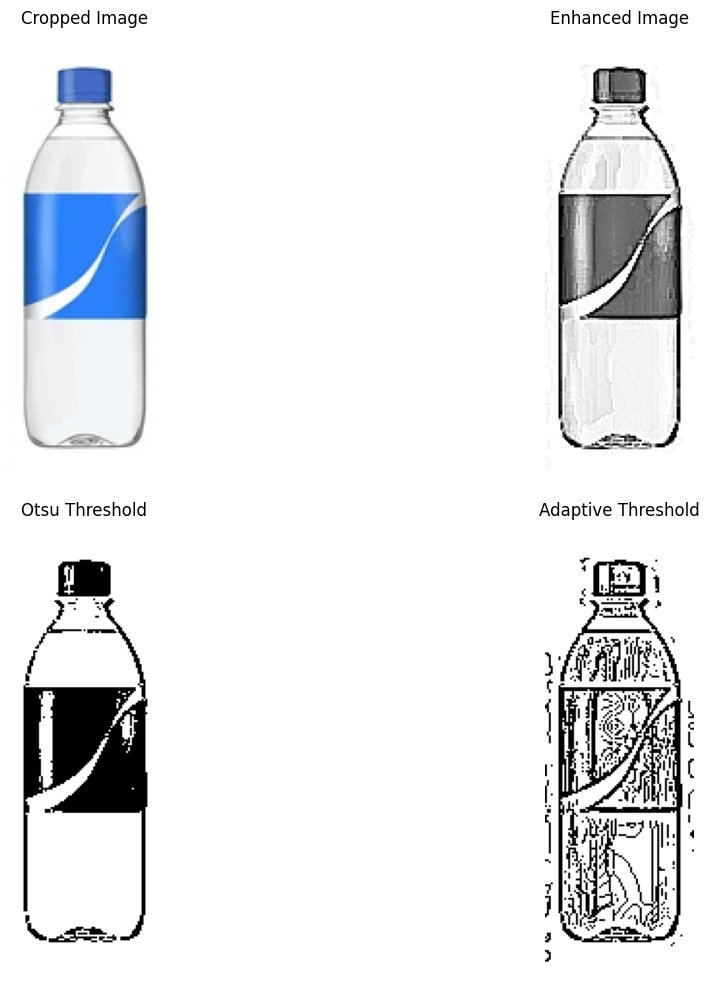

🔍 AI Classification: wine bottle
📝 Extracted Text:
Bm carte

🌱 SUSTAINABILITY ANALYSIS REPORT
📦 Product Type: BOTTLE
♻️  Recyclable: ✅ YES
💡 Tip: Check for recycling symbol #1 (PETE) or #2 (HDPE). Most bottles are recyclable!

🔍 Text analysis unavailable - insufficient readable text


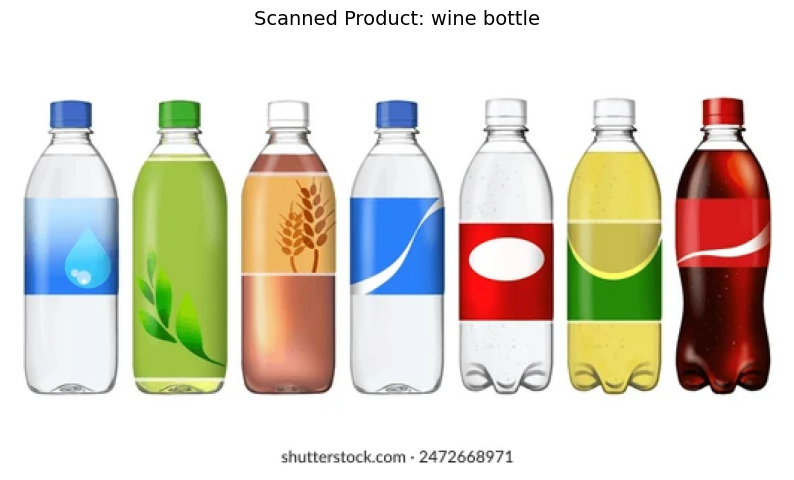

🎯 PRO TIPS FOR BETTER RESULTS:
   • Take clear, well-lit photos of product labels
   • Focus on areas with text and recycling symbols
   • Avoid complex backgrounds and watermarks
   • Ensure text is in focus and readable


In [35]:
# Install required libraries
!pip install tensorflow tensorflow_hub tensorflow_text opencv-python matplotlib pytesseract

# Install system dependencies for Tesseract OCR
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev

import tensorflow as tf
import tensorflow_hub as hub
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pytesseract
from google.colab import files
import tempfile
import os
import re

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Load a pre-trained image classification model from TF Hub
classifier_model_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
classifier = hub.load(classifier_model_url)

# Define image shape
image_shape = (224, 224)

# Load ImageNet labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

def detect_and_crop_product(img):
    """
    Detect the main object in the image and crop to it for better OCR
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply edge detection
    edges = cv2.Canny(gray, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return img  # Return original if no contours found

    # Find the largest contour (likely the main product)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get bounding rectangle
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Add some padding (10% on each side)
    padding_x = int(w * 0.1)
    padding_y = int(h * 0.1)

    x = max(0, x - padding_x)
    y = max(0, y - padding_y)
    w = min(img.shape[1] - x, w + 2 * padding_x)
    h = min(img.shape[0] - y, h + 2 * padding_y)

    # Crop the image
    cropped_img = img[y:y+h, x:x+w]

    return cropped_img

def enhance_image_for_ocr(img):
    """
    Apply multiple enhancement techniques to improve OCR accuracy
    """
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img

    # Apply noise reduction
    denoised = cv2.medianBlur(gray, 3)

    # Improve contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(denoised)

    # Apply sharpening filter
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(contrast_enhanced, -1, kernel)

    return sharpened

def extract_text_from_image(img):
    """
    Enhanced OCR function with multiple strategies
    """
    # First, try to crop to the main product
    try:
        cropped_img = detect_and_crop_product(img)
    except:
        cropped_img = img

    # Enhance the image for OCR
    enhanced_img = enhance_image_for_ocr(cropped_img)

    # Try multiple thresholding techniques
    _, thresh1 = cv2.threshold(enhanced_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh2 = cv2.adaptiveThreshold(enhanced_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # Try different OCR configurations
    configs = [
        r'--oem 3 --psm 6',  # Uniform block of text
        r'--oem 3 --psm 8',  # Single word
        r'--oem 3 --psm 11', # Sparse text
        r'--oem 3 --psm 4'   # Single column of text
    ]

    best_text = ""
    max_alpha_chars = 0

    for config in configs:
        for processed_img in [thresh1, thresh2, enhanced_img]:
            try:
                text = pytesseract.image_to_string(processed_img, config=config)
                # Clean up the text
                text = re.sub(r'[^\w\s]', ' ', text)  # Remove special characters
                text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

                alpha_chars = sum(1 for c in text if c.isalnum())

                if alpha_chars > max_alpha_chars and alpha_chars > 3:
                    max_alpha_chars = alpha_chars
                    best_text = text
            except:
                continue

    return best_text if best_text else "No readable text found"

def debug_ocr_preprocessing(img):
    """Show the steps of image preprocessing for OCR"""
    try:
        cropped_img = detect_and_crop_product(img)
    except:
        cropped_img = img

    enhanced_img = enhance_image_for_ocr(cropped_img)

    _, thresh1 = cv2.threshold(enhanced_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh2 = cv2.adaptiveThreshold(enhanced_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 11, 2)

    # Display all processing steps
    images = [cropped_img, enhanced_img, thresh1, thresh2]
    titles = ['Cropped Image', 'Enhanced Image', 'Otsu Threshold', 'Adaptive Threshold']

    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(2, 2, i+1)
        if i == 0:
            plt.imshow(images[i])
        else:
            plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Enhanced sustainability database
sustainability_db = {
    "bottle": {"recyclable": True, "tip": "Check for recycling symbol #1 (PETE) or #2 (HDPE). Most bottles are recyclable!"},
    "can": {"recyclable": True, "tip": "Aluminum cans are highly recyclable and valuable. Always recycle them!"},
    "wrapper": {"recyclable": False, "tip": "Most plastic wrappers are not recyclable. Look for store take-back programs."},
    "paper": {"recyclable": True, "tip": "Cardboard and paper are recyclable if clean and dry. Remove any plastic windows."},
    "plastic": {"recyclable": True, "tip": "Check the recycling number (1-7). Avoid #3, #6, and #7 which are harder to recycle."},
    "container": {"recyclable": True, "tip": "Many food containers are recyclable. Rinse them clean first."},
    "carton": {"recyclable": True, "tip": "Milk and juice cartons are recyclable in most communities. Check local guidelines."},
    "glass": {"recyclable": True, "tip": "Glass is infinitely recyclable! Rinse and remove lids before recycling."},
}

# Enhanced keyword list with patterns
sustainability_keywords = {
    "good": [
        "recyclable", "compostable", "biodegradable", "recycled content", "FSC certified",
        "PET", "PETE", "HDPE", "aluminum", "cardboard", "glass", "paper", "recycle",
        r"\b\d0%\s*recycled\b", "sustainable", "eco.friendly", "planet friendly"
    ],
    "bad": [
        "not recyclable", "plastic #7", "mixed materials", "landfill", "styrofoam",
        "polystyrene", "throw away", "disposable", "non.recyclable", "plastic #6",
        "plastic #3", "PVC", "trash", "garbage"
    ]
}

def preprocess_image(img):
    img = cv2.resize(img, image_shape)
    img = img / 255.0  # Normalize to [0,1]
    img = img.astype(np.float32)
    return tf.expand_dims(img, 0)

def analyze_sustainability_text(text, product_type):
    """
    Advanced text analysis for sustainability information
    """
    text_lower = text.lower()
    findings = []
    confidence = 0

    # Check for good keywords with pattern matching
    for pattern in sustainability_keywords["good"]:
        if re.search(pattern, text_lower, re.IGNORECASE):
            findings.append(f"✅ Found positive indicator: '{pattern}'")
            confidence += 1

    # Check for bad keywords
    for pattern in sustainability_keywords["bad"]:
        if re.search(pattern, text_lower, re.IGNORECASE):
            findings.append(f"⚠️ Found concerning indicator: '{pattern}'")
            confidence -= 1

    # Special checks for specific product types
    if "bottle" in product_type.lower() or "plastic" in product_type.lower():
        # Look for recycling codes
        recycling_codes = re.findall(r'[1-7]', text)
        if recycling_codes:
            findings.append(f"♻️ Found recycling code(s): {', '.join(recycling_codes)}")
            if '1' in recycling_codes or '2' in recycling_codes:
                confidence += 2
            elif '7' in recycling_codes:
                confidence -= 1

    return findings, confidence

def analyze_product(img_path):
    # 1. Read and preprocess the image
    img = cv2.imread(img_path)
    if img is None:
        print("❌ Error: Could not load image")
        return

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    print("📐 Product Detection and Enhancement:")
    debug_ocr_preprocessing(img)

    # 2. Classify the product
    processed_img = preprocess_image(img)
    predictions = classifier(processed_img)
    predicted_index = np.argmax(predictions[0], axis=-1)

    if predicted_index < len(imagenet_labels):
        predicted_product = imagenet_labels[predicted_index]
    else:
        predicted_product = "Unknown product"

    print(f"🔍 AI Classification: {predicted_product}")

    # 3. Extract Text with enhanced OCR
    extracted_text = extract_text_from_image(img)
    print(f"📝 Extracted Text:\n{extracted_text}\n")

    # 4. Analyze for Sustainability
    print("🌱 SUSTAINABILITY ANALYSIS REPORT")
    print("=" * 50)

    # Product type analysis
    product_found = False
    for product_type, info in sustainability_db.items():
        if product_type in predicted_product.lower():
            product_found = True
            status = "✅ YES" if info['recyclable'] else "❌ NO"
            print(f"📦 Product Type: {product_type.upper()}")
            print(f"♻️  Recyclable: {status}")
            print(f"💡 Tip: {info['tip']}")
            break

    if not product_found:
        print(f"📦 Product Type: {predicted_product}")
        print("⚠️  Product type not in database. Analysis based on visual features.")
        if any(word in predicted_product.lower() for word in ["bottle", "container", "package", "packaging"]):
            print("✅ Likely recyclable packaging material")
            print("💡 Check for recycling symbols and local guidelines")

    # Text analysis
    if extracted_text != "No readable text found" and len(extracted_text) > 10:
        findings, confidence = analyze_sustainability_text(extracted_text, predicted_product)

        if findings:
            print("\n🔍 TEXT ANALYSIS FINDINGS:")
            for finding in findings:
                print(f"   {finding}")

            # Overall confidence assessment
            if confidence > 2:
                print("\n🎯 CONFIDENCE: High - This product appears environmentally friendly")
            elif confidence > 0:
                print("\n🎯 CONFIDENCE: Medium - Mixed sustainability indicators")
            else:
                print("\n🎯 CONFIDENCE: Low - Potential sustainability concerns")
        else:
            print("\n🔍 No specific sustainability keywords found in text")
    else:
        print("\n🔍 Text analysis unavailable - insufficient readable text")

    # 5. Display results
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Scanned Product: {predicted_product}", fontsize=14, pad=20)
    plt.show()

    print("=" * 50)
    print("🎯 PRO TIPS FOR BETTER RESULTS:")
    print("   • Take clear, well-lit photos of product labels")
    print("   • Focus on areas with text and recycling symbols")
    print("   • Avoid complex backgrounds and watermarks")
    print("   • Ensure text is in focus and readable")

def run_analysis():
    print("🤖 SMART SHOPPER AI: SUSTAINABILITY SCANNER")
    print("=" * 55)
    print("📸 Upload images of products for instant sustainability analysis!")
    print("   Recommended: Packaging with visible text and symbols")
    print()

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n{'='*60}")
        print(f"🔍 ANALYZING: {filename}")
        print(f"{'='*60}")
        analyze_product(filename)

# Run the analysis
run_analysis()